# Load sign embeddings

In [280]:
import io
import numpy as np

def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

print("Setup complete.")

Setup complete.


In [315]:
## PMI+SVD ############################
dim=32
# src_path = './embeddings/pmi_svd/output/PE_nonnumeric.txt.vec'
# tgt_path = './embeddings/pmi_svd/output/PC_nonnumeric.txt.vec'
# ########
# src_path = './embeddings/pmi_svd/output/PE.txt.{0}.vec'.format(dim)
# tgt_path = './embeddings/pmi_svd/output/PC.txt.{0}.vec'.format(dim)

## fastText ############################
# src_path = './embeddings/fastText/models/PE_nonnumeric.cbow.vec'
# tgt_path = './embeddings/fastText/models/PC_nonnumeric.cbow.vec'
# ########
# src_path = './embeddings/fastText/models/PE_nonnumeric.skip.vec'
# tgt_path = './embeddings/fastText/models/PC_nonnumeric.skip.vec'
# ########
# src_path = './embeddings/fastText/models/PE.cbow.vec' # < this is what MUSE used as input ***
# tgt_path = './embeddings/fastText/models/PC.cbow.vec' # < this is what MUSE used as input ***
# ########
# src_path = './embeddings/fastText/models/PE.skip.vec'
# tgt_path = './embeddings/fastText/models/PC.skip.vec'

## MUSE ############################
# curently trained on 8-dim. fastText, incl. numeric
# src_path = './embeddings/aligned/vectors-pe_supervised.vec'
# tgt_path = './embeddings/aligned/vectors-pc_supervised.vec'
# ########
src_path = './embeddings/aligned/vectors-pe_unsupervised.vec'
tgt_path = './embeddings/aligned/vectors-pc_unsupervised.vec'

nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

print("Loaded embeddings from\n", src_path, "and\n", tgt_path)

Loaded embeddings from
 ./embeddings/aligned/vectors-pe_unsupervised.vec and
 ./embeddings/aligned/vectors-pc_unsupervised.vec


# Nearest neighbors

Given a sign in one script, what signs does the embedding model think are most similar?

In [316]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5, verbose=True):
    if verbose:
        print("Nearest neighbors of \"%s\":" % word)
    nns = []
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        if verbose:
            print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))
        nns.append( (scores[idx], tgt_id2word[idx]) )
    return nns

print("Set up nearest-neighbor function.")

Set up nearest-neighbor function.


In [317]:
# printing nearest neighbors in the source space
src_word = 'M388'
_ = get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=15)

Nearest neighbors of "M388":
1.0000 - M388
0.9999 - M056~f
0.9999 - M059~d
0.9999 - |M106~2+M288|
0.9999 - M096~d
0.9999 - M057~a
0.9999 - M136~b
0.9999 - |M370+M388+M370|
0.9999 - |M218~d+M288|
0.9999 - |M327+X|
0.9999 - M057~b1
0.9999 - |M106+M288|
0.9999 - M057~b
0.9999 - |M054+M365+M054~i|
0.9999 - |M157+M288|


Given a sign in one script, which signs from the *other* script are functionally similar?

In [322]:
# printing nearest neighbors in the target space
src_words = ["M157","M388","M346","M072","|M288+N01|"]
for src_word in src_words:
    _ = get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=15)
    print()

Nearest neighbors of "M157":
0.9995 - BAR
0.9994 - USZUMGAL
0.9994 - |DU8~cxAMAR|
0.9993 - SUKUD
0.9993 - NIMGIR
0.9991 - |BAD&BAD|
0.9991 - GESZTU~b
0.9991 - |DU8~cxUDU~a|
0.9990 - SZAKIR~c
0.9990 - SUG
0.9990 - SUHUR@n
0.9989 - GUKKAL~c
0.9989 - GISZIMMAR~b1
0.9988 - GESZTU~c3
0.9987 - |GA2~a1xGESZTU~c5|

Nearest neighbors of "M388":
0.9998 - BAR
0.9996 - |DU8~cxAMAR|
0.9996 - USZUMGAL
0.9990 - SIG2~a2
0.9990 - NIMGIR
0.9990 - GESZTU~b
0.9990 - BAHAR2~c
0.9990 - AB2
0.9989 - |BAD&BAD|
0.9989 - GUKKAL~c
0.9988 - DIN
0.9988 - GADA~b@g
0.9988 - ABGAL
0.9987 - SZAKIR~c
0.9987 - GESZTU~c3

Nearest neighbors of "M346":
0.9997 - USZUMGAL
0.9993 - |DU8~cxAMAR|
0.9993 - BAR
0.9992 - GESZTU~b
0.9991 - SIG2~a2
0.9990 - NIMGIR
0.9990 - SZAKIR~c
0.9990 - SIG7
0.9989 - ABGAL
0.9989 - BAHAR2~c
0.9989 - SUKUD
0.9989 - GISZIMMAR~b1
0.9988 - GUKKAL~c
0.9988 - MUNSZUB~b
0.9987 - SUHUR@n

Nearest neighbors of "M072":
0.9999 - |DU8~cxAMAR|
0.9997 - USZUMGAL
0.9994 - SZAKIR~c
0.9993 - GESZTU~b
0.9993 - NI

# Visualize multilingual embeddings

In [319]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
# print('Variance: %.2f' % pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    scale = 10
    
    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = scale*Y[:, 0]
    y_coords = scale*Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(20, 16), dpi=120)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='normal')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()
    
print("Ready to plot.")

Ready to plot.


Plots a random selection of words from each script. Points which are close together are more likely to have similar usage.

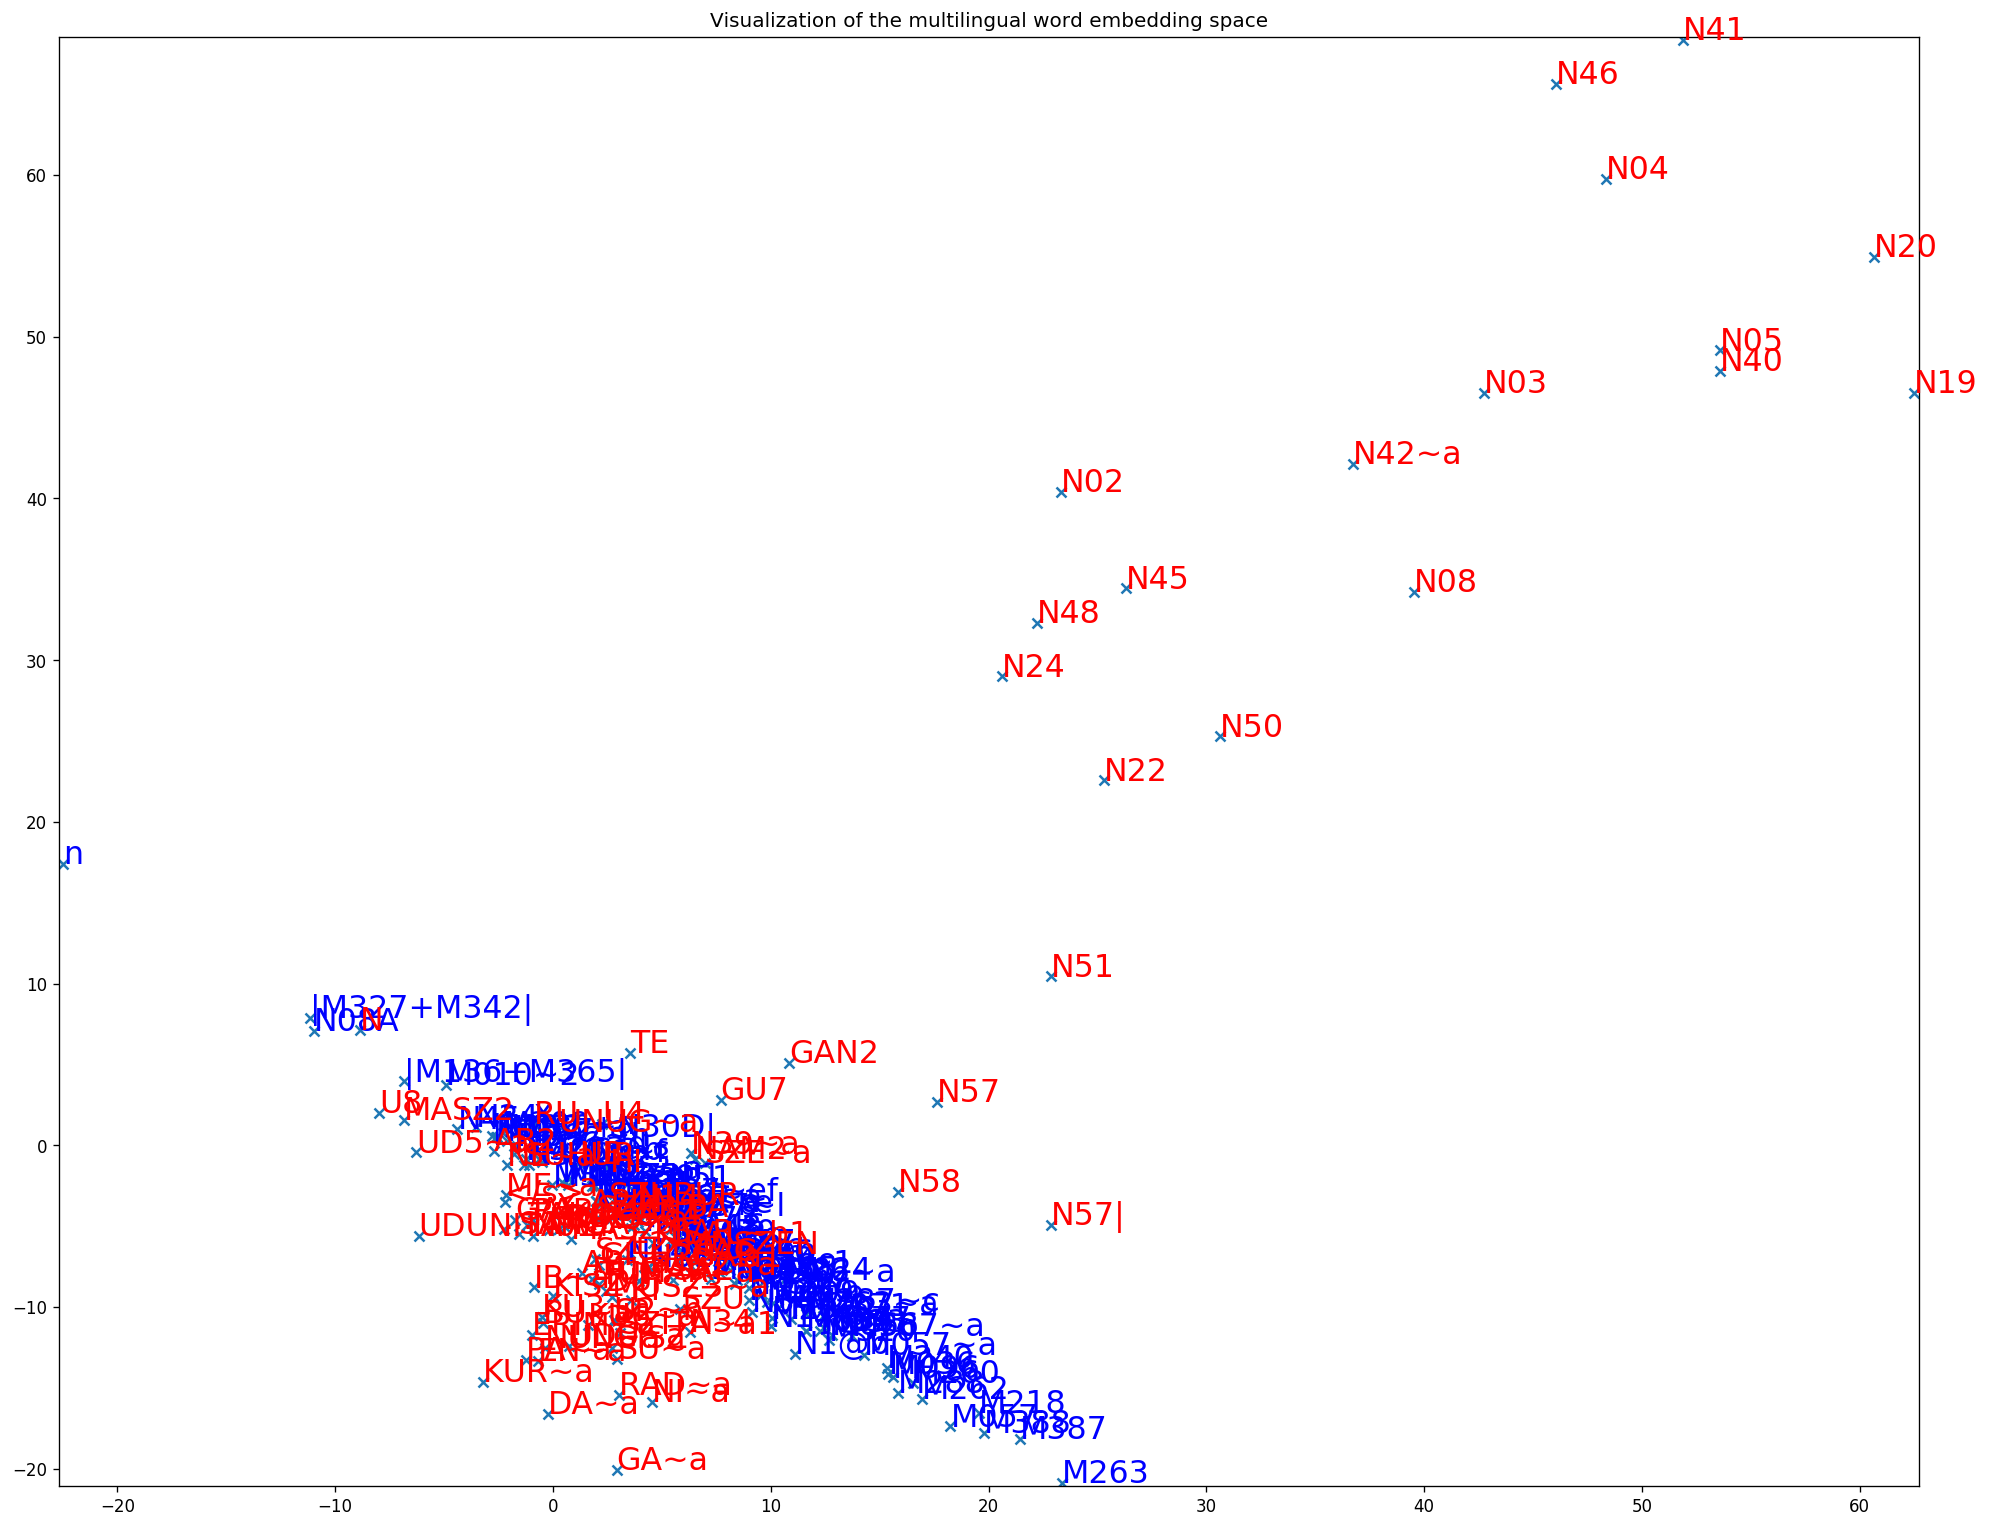

In [323]:
plot_size = 100
src_words = [w for w in src_word2id][:plot_size]
tgt_words = [w for w in tgt_word2id][:plot_size]
# Get the closest target word for source word:
# tgt_words = set([ 
#     get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=1, verbose=False)[0][1] 
#     for src_word in src_words 
# ])

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % tw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

## Highlight source words

See how certain signs cluster within a single script. Plots the entire collection of source words and highlights some signs of interest.

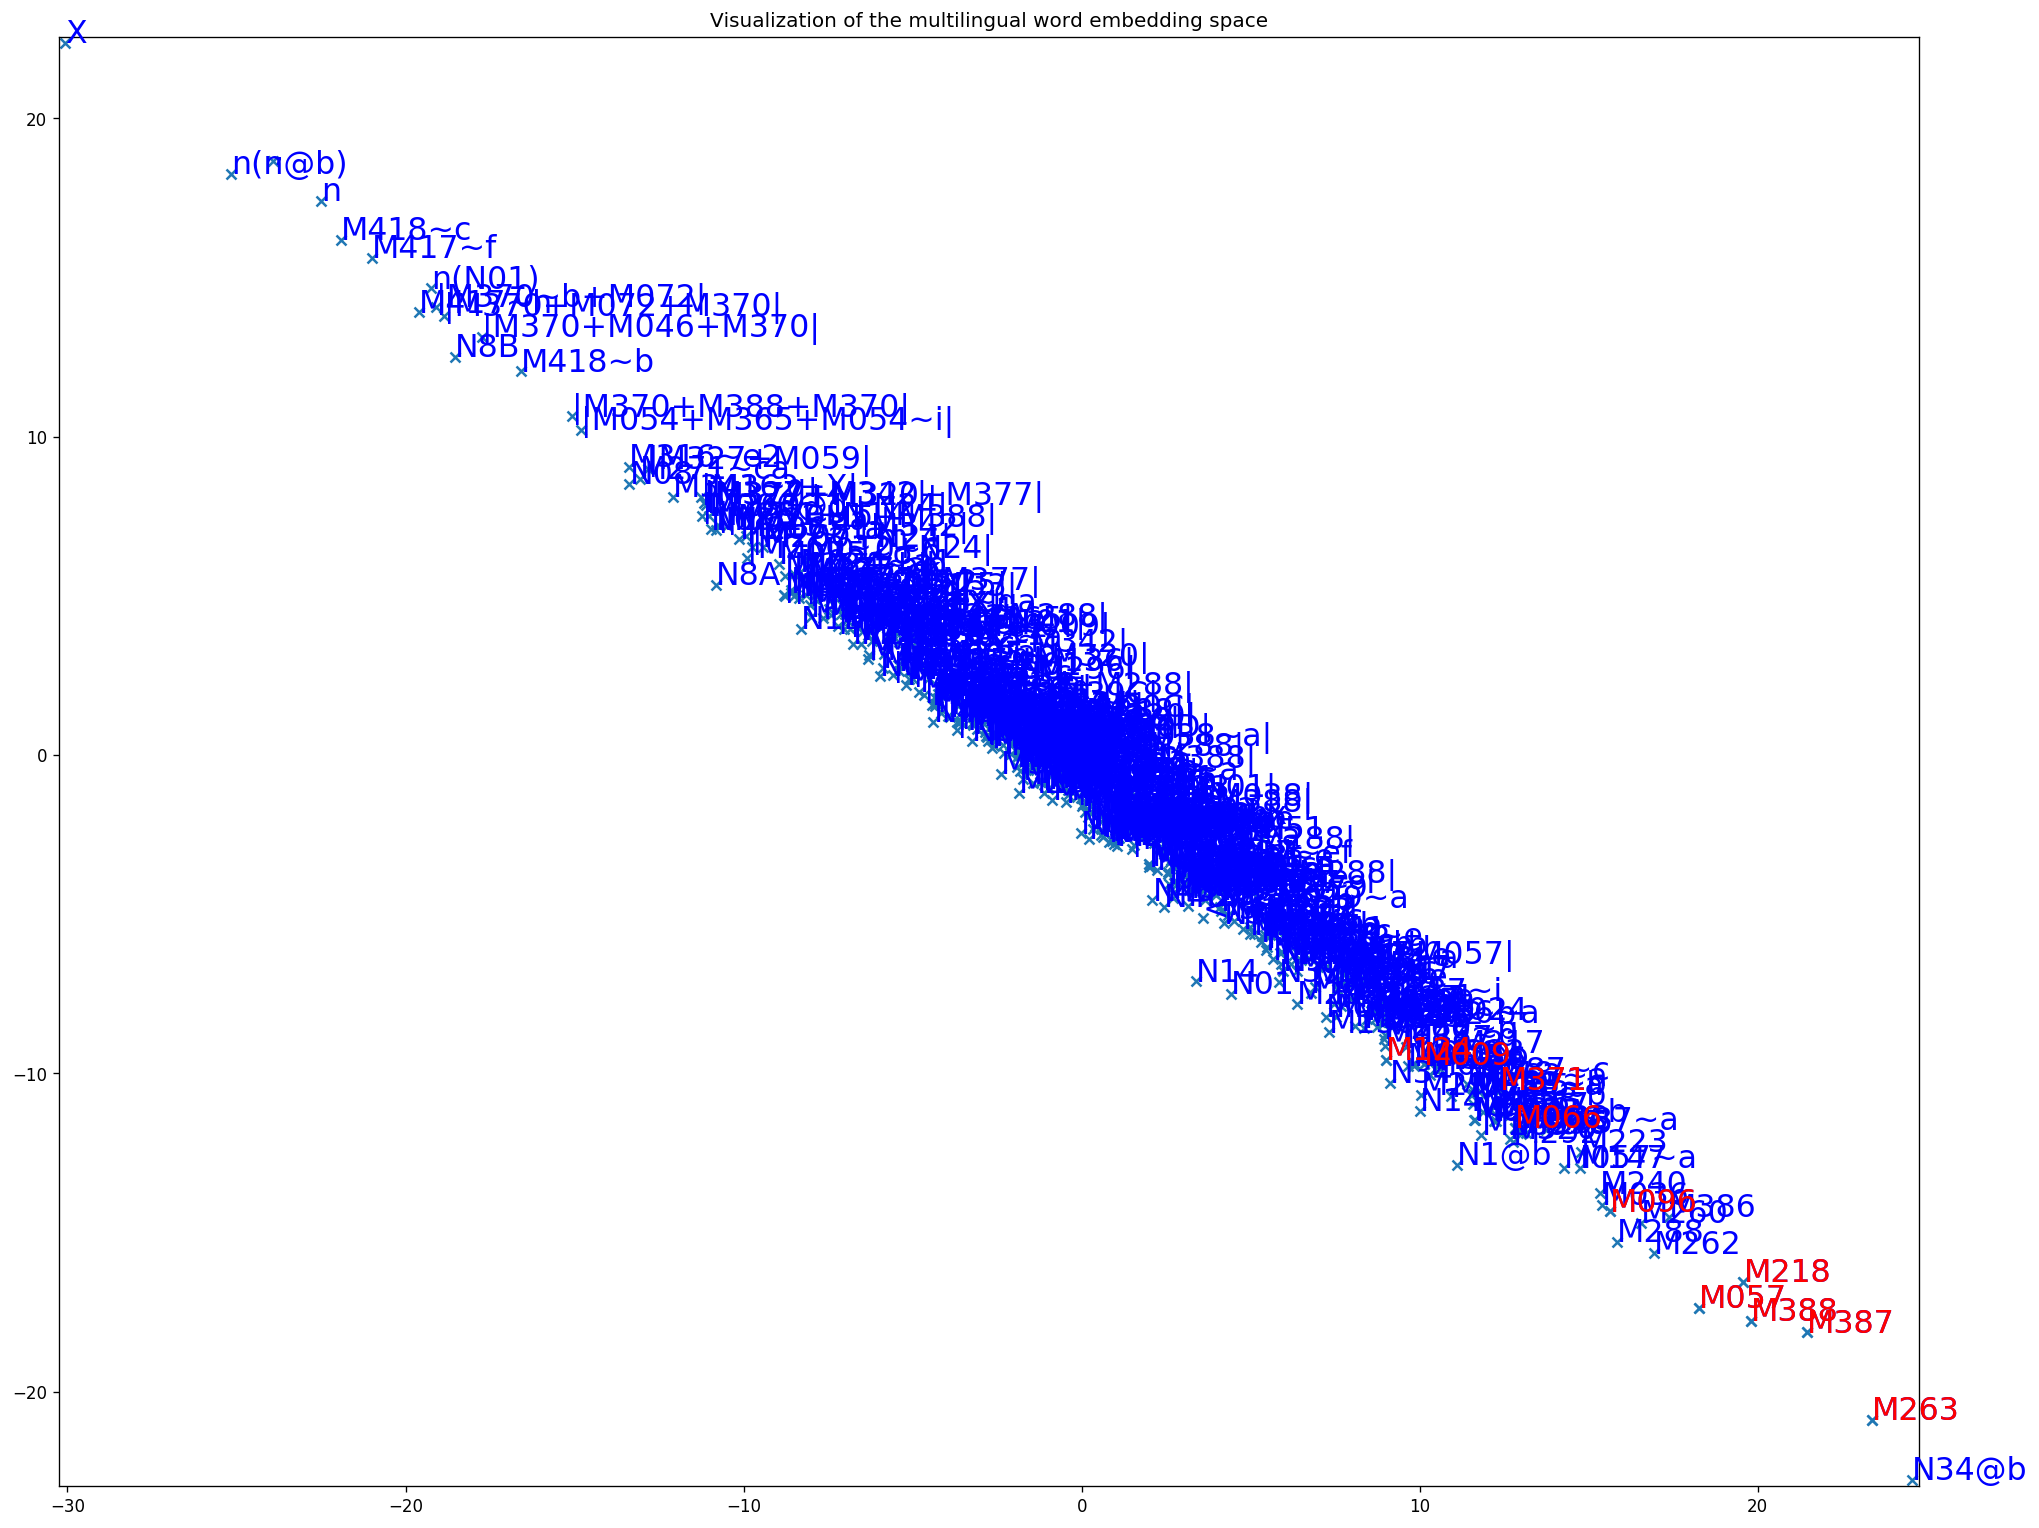

In [321]:
src_words = [w for w in src_word2id]
tgt_words =  ["M388","M066","M096","M218","M387","M371","M124","M009","M263","M057"]

for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in src_word2id, '"%s" not in target dictionary' % tw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, src_word2id, src_embeddings, pca)